In [1]:
import numpy as np
import random
from collections import OrderedDict, defaultdict
from collections import Counter
from scipy.stats import norm
import pandas as pd
from copy import deepcopy

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline


def node_to_idxs(node, N):
    return [node // N, node % N]


def unzip(l):
    return list(zip(*l))

In [2]:
N = 30
board = np.arange(N * N).reshape(N, N)
# board

# Gaussian weights

In [3]:
def normal_subsets(side_len, locality):
    rv = norm(loc=0, scale=locality)
    x = np.linspace(-1, 1, side_len * 2 + 1)
    p = rv.pdf(x)
    peak = side_len
    cols = list(range(side_len))
    subsets = []
    for col in cols:
        start = peak - col
        stop = start + side_len
        subset = np.array(p[start:stop])
        subset /= subset.sum()
        subsets.append(subset)
    for subset in subsets:
        assert np.isclose(subset.sum(), 1.0)
    return subsets

In [4]:
def gen_gauss_weights(subsets):
    weights = []
    for i, col in enumerate(subsets):
        for j, row in enumerate(subsets):
            X, Y = np.meshgrid(row, col)
            w = X * Y
            w[i][j] = 0
            w /= w.sum()
            weights.append(w.flatten())
    return np.array(weights)

In [5]:
def show_weights(weights, N):
    i = 0
    while i < len(weights):
        w = weights[i].reshape(N, N)
        plt.imshow(w)
        plt.show()
        i += np.random.randint(N ** 2 // 3)


def show_3d_weights(weights, N):
    fig = plt.figure()
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, N)
    Y = np.arange(0, N)
    X, Y = np.meshgrid(X, Y)
    Z = weights.reshape(N, N)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)

    # Customize the z axis.
    # a x.set_zlim(0, .001)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

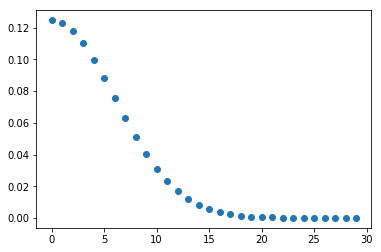

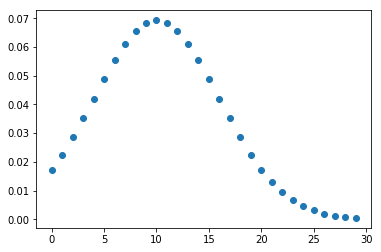

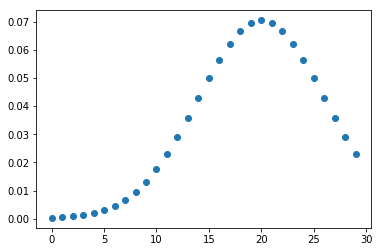

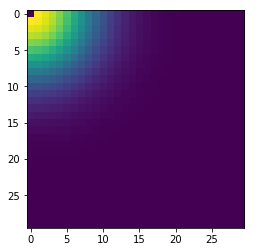

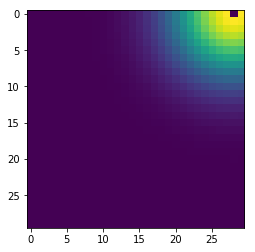

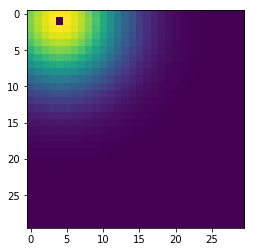

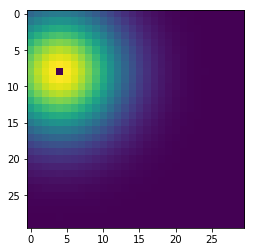

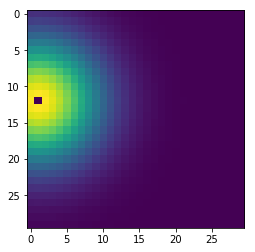

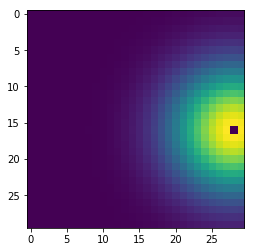

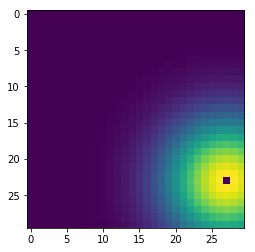

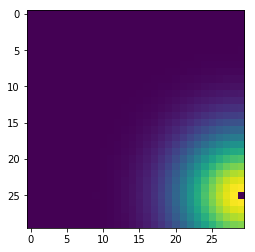

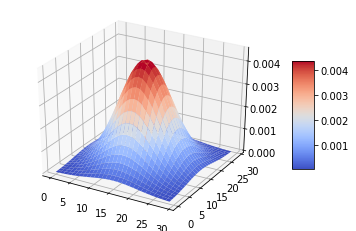

In [6]:
subsets = normal_subsets(N, 0.2)
for subset in subsets[::10]:
    plt.plot(subset, "o")
    plt.show()
weights = gen_gauss_weights(subsets)
show_weights(weights, N)
show_3d_weights(weights[int(N * (N - 1) / 2)], N)

# Uniform weights

In [7]:
def gen_unif_weights(N):
    w = np.ones((N ** 2, N ** 2))
    return w / N ** 2

In [8]:
weights = gen_unif_weights(N)

In [9]:
weights

array([[0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111],
       [0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111],
       [0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111],
       ...,
       [0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111],
       [0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111],
       [0.00111111, 0.00111111, 0.00111111, ..., 0.00111111, 0.00111111,
        0.00111111]])

# Sampling

## Gaussian

In [10]:
node = N * (N - 1) // 2
subsets = normal_subsets(N, 0.2)
weights = gen_gauss_weights(subsets)

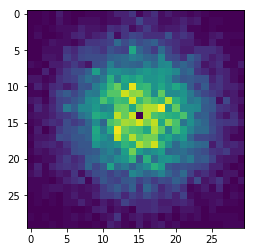

In [11]:
nodes = np.arange(N * N)
samples = [
    np.random.choice(nodes, p=weights[node], replace=False, size=1)[0]
    for _ in range(10000)
]

samples = Counter(samples).most_common()

results = np.zeros_like(board)
for coord, count in samples:
    x, y = coord // N, coord % N
    results[x][y] = count
plt.imshow(results)

In [12]:
samples = [
    np.random.choice(np.arange(N * N), p=weights[node], replace=False, size=899)
    for _ in range(1000)
]

In [13]:
def check_position(samples, node):
    nodes = []
    for sample in samples:
        nodes.append(sample[node])

    nodes = Counter(nodes).most_common()
    results = np.zeros_like(board)
    for coord, count in nodes:
        x, y = coord // N, coord % N
        results[x][y] = count
    plt.imshow(results)
    plt.show()

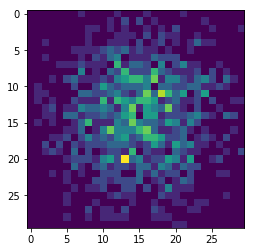

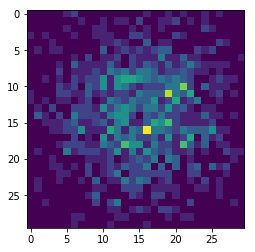

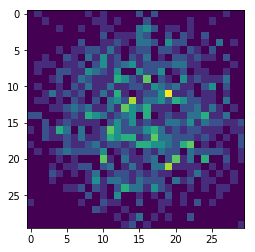

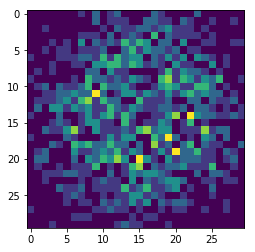

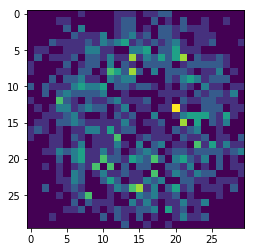

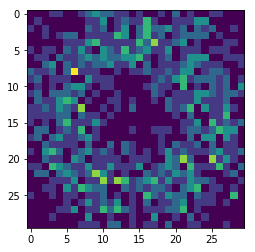

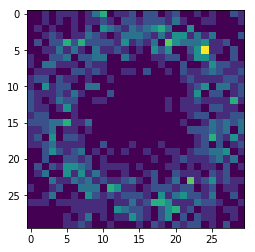

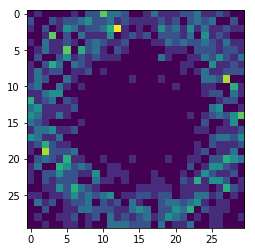

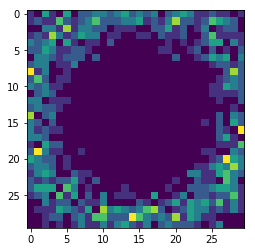

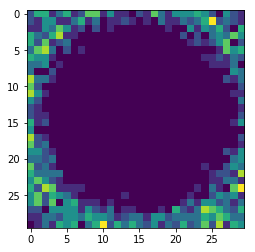

In [14]:
for i in range(0, N ** 2 - 1, N ** 2 // 10):
    check_position(samples, i)

In [81]:
class Network:
    def __init__(self, N, opts, stage=False):
        self.N = N
        self.adjM = np.zeros((N**2, N**2))
        self.adjL = defaultdict(set)
        self.nodes = np.arange(N ** 2)
        self.stage = stage
        if opts["distr"] == "gauss":
            self.distr = opts["distr"]
            self.locality = opts["locality"]
            subsets = normal_subsets(self.N, self.locality)
            self.weights = gen_gauss_weights(subsets)

        elif opts["distr"] == "unif":
            self.distr = opts["distr"]
            self.weights = gen_unif_weights(self.N)
        else:
            raise RuntimeError("Distribution not implemented: " + opts["distr"])
        
        if(stage == False):
            self.stage = Network(N, opts, stage=True)

    def add_edges(self,node, num_samples):
        num_samples = max(num_samples, N - 1 - len(self.stage.adjL[node]))
        samples = np.random.choice(
            self.nodes, p=self.stage.weights[node], replace=False, size=num_samples
        )
        for sample in samples:
            self.stage.weights[node][sample] = 0
            self.stage.adjM[node][sample] = 1
            self.stage.adjL[node].add(sample)
            
        self.stage.weights[node] /= self.stage.weights[node].sum()
        
        return samples

    def commit(self):
        self.adjM = np.copy(self.stage.adjM)
        self.adjL = deepcopy(self.stage.adjL)
        self.weights = np.copy(self.stage.weights)

    def undo(self):
        self.stage.adjM = np.copy(self.adjM)
        self.stage.adjL = deepcopy(self.adjL)
        self.stage.weights = np.copy(self.weights)
    
    def show_adj(self):
        plt.figure(figsize=(10,10))
        plt.imshow(self.stage.adjM)
        plt.show()

In [82]:
g_opts = {"distr": "gauss", "locality": 0.2}
# g_opts = {"distr": "gauss", "locality": 1}
u_opts = {"distr": "unif"}

In [83]:
net = Network(30, g_opts)

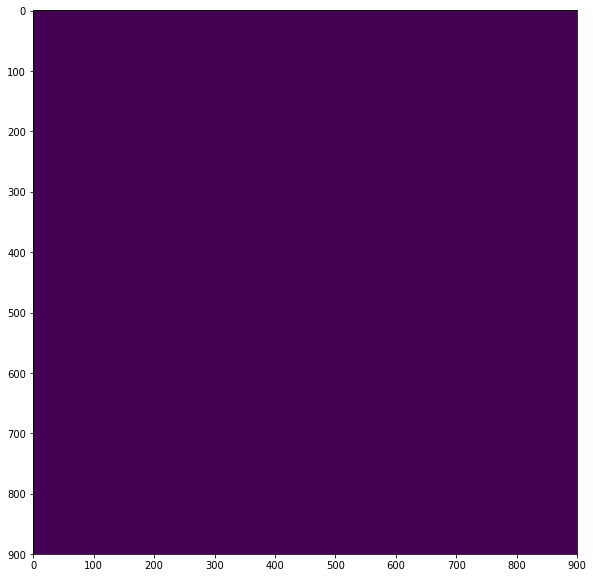

In [84]:
net.show_adj()

In [85]:
node = 13*20
net.add_edges(node, 100)

array([221, 377, 113, 273, 532, 414, 438, 176, 584, 233,  89, 322, 192,
       407, 314, 561, 217, 256, 286, 111,   9, 193, 557, 416, 203, 410,
       464, 201, 400, 194, 199, 319,  50, 403, 171, 406, 236, 520, 289,
       465, 372,  19, 474, 547,  43, 351, 188,  74,  86, 401, 350, 628,
        20, 436, 276, 503, 315,  21, 196, 149, 281, 456,  38, 158, 254,
        54,  79, 379, 115, 478, 563, 287, 283,  71, 170, 530, 321, 534,
       202, 526, 107, 621, 138,  47, 135, 197,  82, 358,  95, 291, 290,
       262, 229, 141, 137, 354,  76, 258, 443, 263])

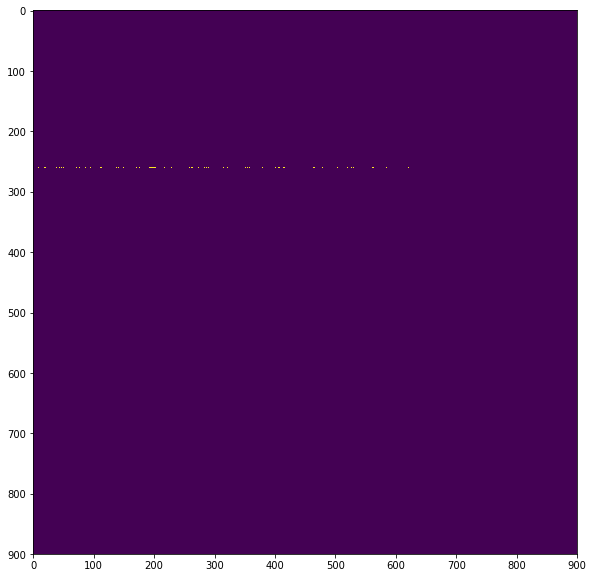

In [86]:
net.show_adj()

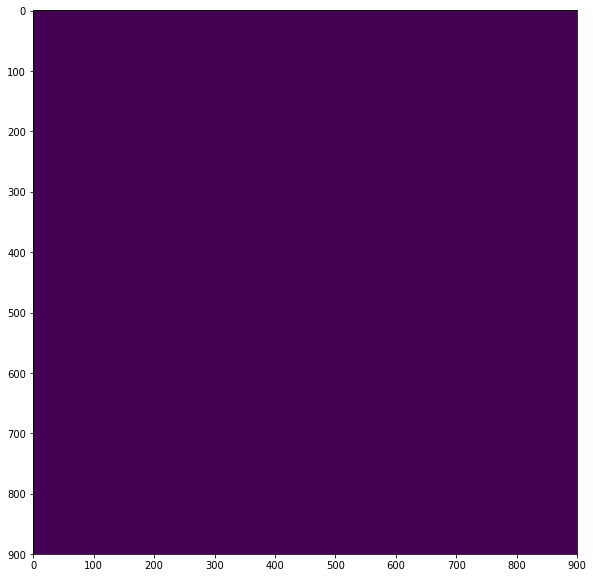

In [87]:
net.undo()
net.show_adj()

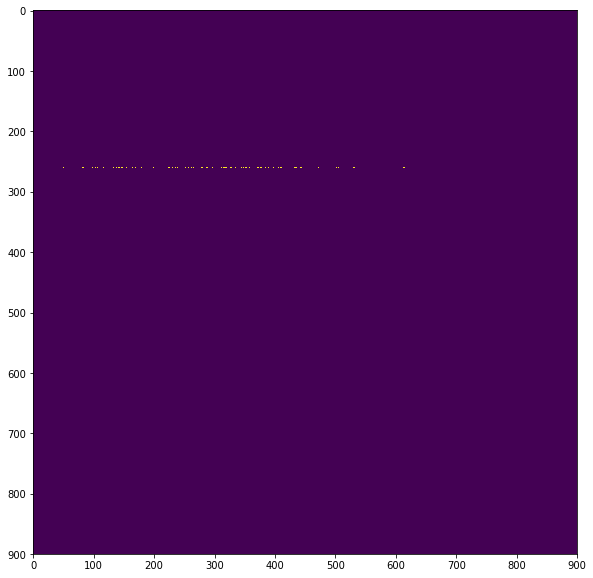

In [88]:
net.add_edges(node, 100)
net.show_adj()

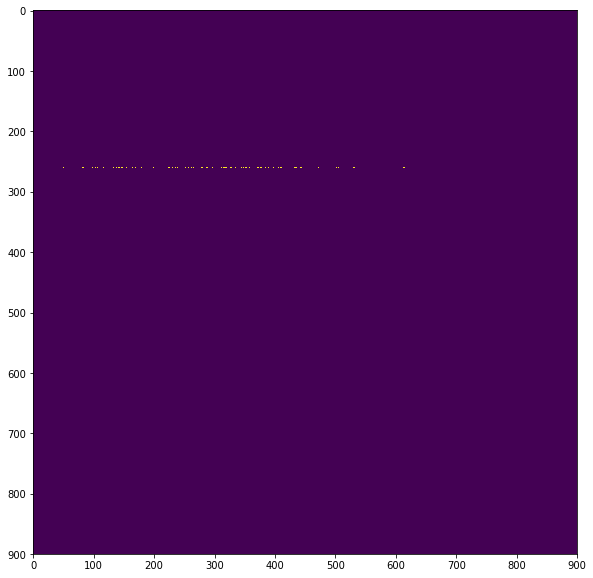

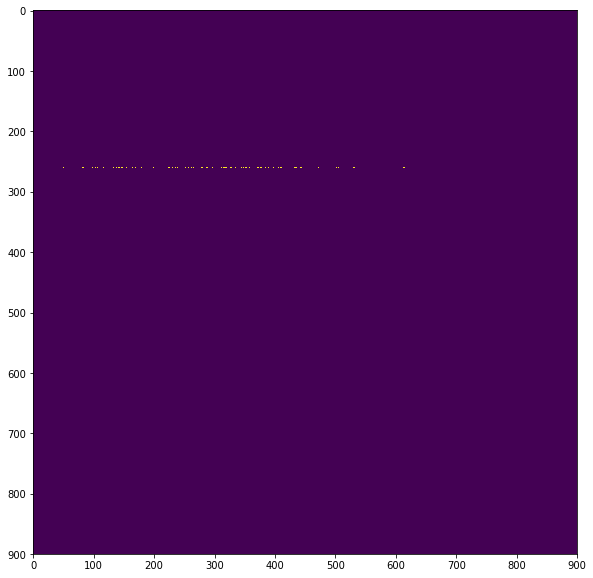

In [90]:
net.commit()
net.show_adj()
plt.figure(figsize=(10,10))
plt.imshow(net.adjM)
plt.show()

## Uniform